In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import interpolate
import torch
import torch.nn as nn
torch.manual_seed(0)
np.random.seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

In [2]:
def DEIM(U):
    """
    Compute DEIM interpolation indices given
    U = {u_i}_i matrix with linearly independent columns.
    """
    U = np.copy(U)
    selected_indices = []
    
    for i in range(U.shape[1]):
        idx = np.argmax(np.abs(U[:, i]))
        selected_indices.append(idx)
        U = U - 1/U[idx, i] * U[:, [i]] @ U[[idx], :]
    
    return selected_indices

In [3]:
def Exact_NEIM(mu, f, U, max_modes=25):
    """
    Compute a non-neural network NEIM for solution
    independent nonlinearities.
    
    mu: parameters
    f:  nonlinearity corresponding to each mu in a matrix
    U:  POD basis
    """
    
    Pf = U.T @ f # projection of f
    
    selected_parameters = []
    selected_indices = []
    trained_networks = []
    
    # NEIM Step 1
    idx = np.argmax([np.linalg.norm(Pf[:, i])**2 for i in range(Pf.shape[1])])
    mu_1 = mu[idx]
    selected_parameters.append(mu_1)
    selected_indices.append(idx)
    
    NN_1 = np.copy(Pf[:, [idx]])
    NN_1 /= np.linalg.norm(NN_1)
    trained_networks.append(NN_1)
    thetas = np.array([np.dot(NN_1.reshape(-1), Pf[:, i])/np.linalg.norm(NN_1)**2 for i in range(Pf.shape[1])])
    current_approximation = thetas * NN_1
    
    # NEIM Update Step
    for i in range(1, max_modes):
        idx = np.argmax([np.linalg.norm(current_approximation[:, i] - Pf[:, i])**2 for i in range(Pf.shape[1])])
        mu_i = mu[idx]
        selected_parameters.append(mu_i)
        selected_indices.append(idx)
        
        # orthogonalize selected vector with respect to previous vectors
        NN_i = Pf[:, [idx]]
        for network in trained_networks:
            NN_i -= np.dot(NN_i.reshape(-1), network.reshape(-1)) * network / np.linalg.norm(network)**2
        NN_i /= np.linalg.norm(NN_i)
        
        trained_networks.append(NN_i)
        A = np.zeros((i+1, i+1))
        for j in range(A.shape[0]):
            for k in range(A.shape[1]):
                A[j, k] = np.dot(trained_networks[j].reshape(-1), trained_networks[k].reshape(-1))
        
        thetas = []
        for j in range(Pf.shape[1]):
            b = np.zeros((i+1, 1))
            for k in range(b.shape[0]):
                b[k, 0] = np.dot(trained_networks[k].reshape(-1), Pf[:, j])
            thetas.append(np.linalg.solve(A, b).reshape(-1))
        thetas = np.array(thetas).T
        current_approximation = np.array(trained_networks)[:, :, 0].T @ thetas
    
    trained_networks = np.array(trained_networks)[:, :, 0].T
    
    def Exact_NEIM_approximation(new_mu, num_modes=-1):
        if num_modes == -1:
            num_modes = trained_networks.shape[1]
        thetas_ = interpolate.griddata(mu, thetas.T, new_mu, method='cubic').reshape(-1, 1)
        if True in np.isnan(thetas_):
            thetas_ = interpolate.griddata(mu, thetas.T, new_mu, method='nearest').reshape(-1, 1)
        return U @ (trained_networks[:, :num_modes] @ thetas_[:num_modes])
    
    return Exact_NEIM_approximation, selected_indices

In [37]:
# Note that in the example, there is no actual input for
# the neural network. Instead, to simulate NEIM, we will
# choose a simple "solution".

def solution_fn(mu, f):
    # compute full order solutions
    sols = np.zeros((mu.shape[0], f.shape[0]), dtype=np.double)
    A = 2*np.eye(f.shape[0], dtype=np.double) - np.eye(f.shape[0], k=1, dtype=np.double) - np.eye(f.shape[0], k=-1, dtype=np.double)
    A = 30 * A
    A = A[1:-1, 1:-1]
    
    for i, m in enumerate(mu): # loop over parameters for nonlinearity
        sol = np.zeros((f.shape[0], 1), dtype=np.double)
        sol[1:-1] = np.linalg.solve(A, f[1:-1, [i]])
        sol = sol.reshape(-1)
        sols[i] = sol
            
    return sols

class Net(nn.Module):
    def __init__(self, in_size, out_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_size, 1)
        #self.fc2 = nn.Linear(30, 30)
        #self.fc4 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(1, out_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        #x = self.fc2(x)
        #x = torch.tanh(x)
        #x = self.fc4(x)
        #x = torch.tanh(x)
        x = self.fc3(x)
        return x

def NEIM(ro_sols, f_NEIM, mu, V, max_modes=10, train_loop_iterations=10000):
    """
    Compute NEIM for solution
    independent nonlinearities.
    """
    NUM_PARAMS = f_NEIM.shape[0]
    RO_DIM = ro_sols.shape[1]
    
    selected_indices = []
    trained_networks = []
    
    # NEIM Step 1
    errors = np.zeros(NUM_PARAMS)
    for i in range(NUM_PARAMS):
        # compute error
        s = 0
        for j in range(NUM_PARAMS):
            s += np.sum(f_NEIM[i, j]**2)
        errors[i] = s / NUM_PARAMS
    
    idx = np.argmax(errors)
    selected_indices.append(idx)
    print(idx, "Max Error:", errors[idx], "Mean Error:", np.mean(errors))
    
    Network_mu_1 = Net(RO_DIM, RO_DIM)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(Network_mu_1.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)
    
    x_data = torch.tensor(ro_sols, dtype=torch.double)
    y_data = torch.tensor(np.array([f_NEIM[idx, j]/np.linalg.norm(f_NEIM[idx, j]) for j in range(f_NEIM.shape[1])]), dtype=torch.double)
    #y_data = torch.tensor(f_NEIM[idx], dtype=torch.double)
    
    for epoch in range(train_loop_iterations):
        optimizer.zero_grad()
        output = Network_mu_1(x_data)
        loss = criterion(output, y_data)
        if epoch % 100 == 0:
            print(epoch, loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
        #scheduler.step(loss)
    
    Network_mu_1.eval()
    trained_networks.append(Network_mu_1)
    
    thetas = np.zeros((NUM_PARAMS, 1), dtype=np.double)
    for i in range(NUM_PARAMS):
        numerator = 0
        denominator = 0
        for j in range(NUM_PARAMS):
            net_u_mu = Network_mu_1(x_data[j].view(1, -1)).detach().numpy().reshape(-1)
            numerator += np.dot(f_NEIM[i, j], net_u_mu)
            denominator += np.dot(net_u_mu, net_u_mu)

        theta_1_1_i = numerator / denominator
        thetas[i] = theta_1_1_i    
    
    for iteration in range(max_modes-1):
        # current approximation
        approx = lambda sol, param_idx: sum([
            thetas[param_idx][i] * net(torch.tensor(sol).view(1, -1)).T.detach().numpy().reshape(-1)\
            for i, net in enumerate(trained_networks)
        ])
    
        
        errors = np.zeros(NUM_PARAMS)
        for i in range(NUM_PARAMS):
            # compute error
            s = 0
            for j in range(NUM_PARAMS):
                s += np.sum((f_NEIM[i, j] - approx(ro_sols[j], i))**2)
            errors[i] = s / NUM_PARAMS
    
        errors[np.array(selected_indices)] = -1
        mu_2_idx = np.argmax(errors)
        selected_indices.append(mu_2_idx)
        print(mu_2_idx, "Max Error:", errors[mu_2_idx], "Mean Error:", np.mean(errors[errors>=0]))
        
        Network_mu_2 = Net(RO_DIM, RO_DIM)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(Network_mu_2.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9)


        # need to do Gram-Schmidt on this matrix
        y_data = np.copy(f_NEIM[mu_2_idx])
        
        for net in trained_networks:
            # form matrix of evaluations for this network
            previous_net_matrix = np.zeros((NUM_PARAMS, f_NEIM.shape[2]), dtype=np.double)
            for i in range(NUM_PARAMS):
                previous_net_matrix[i] = net(x_data[i].view(1, -1)).detach().numpy().reshape(-1)
                y_data[i] -= np.dot(y_data[i], previous_net_matrix[i]) * previous_net_matrix[i] / np.linalg.norm(previous_net_matrix[i])**2

            # subtract out projection of y_data onto previous_net_matrix from y_data
            #for j in range(f_NEIM.shape[1]):
            #    y_data[j] -= np.dot(y_data[j], previous_net_matrix[j]) * previous_net_matrix[j] / np.linalg.norm(previous_net_matrix[j])**2
            
            #y_data -= np.sum(y_data * previous_net_matrix) / np.linalg.norm(previous_net_matrix)**2 * previous_net_matrix
        
        for j in range(f_NEIM.shape[1]):
            y_data[j] = y_data[j] / np.linalg.norm(y_data[j])
        
        y_data = torch.tensor(y_data)
        #y_data = y_data / torch.norm(y_data)
        
        for epoch in range(train_loop_iterations):
            optimizer.zero_grad()
            output = Network_mu_2(x_data)
            loss = criterion(output, y_data)
            if epoch % 100 == 0:
                print(epoch, loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step()
            #scheduler.step(loss)

        Network_mu_2.eval()
        trained_networks.append(Network_mu_2)
        
        # 3c. Find theta_1_2(mu), theta_2_2(mu)
        print("\nFinding theta...")
        num_nets = len(trained_networks)
        thetas = np.zeros((NUM_PARAMS, num_nets), dtype=np.double)
        for i in range(NUM_PARAMS):
            LHS_numerator = np.zeros((num_nets, num_nets), dtype=np.double)
            LHS_denominator = np.zeros((num_nets, num_nets), dtype=np.double)
            RHS_numerator = np.zeros((num_nets, 1), dtype=np.double)
            RHS_denominator = np.zeros((num_nets, 1), dtype=np.double)

            for j in range(NUM_PARAMS):
                nets_u_mu = [net(x_data[j].view(1, -1)).detach().numpy().reshape(-1) for net in trained_networks]

                for k1 in range(num_nets):
                    RHS_numerator[k1] += np.dot(f_NEIM[i, j], nets_u_mu[k1])
                    RHS_denominator[k1] += np.dot(nets_u_mu[k1], nets_u_mu[k1])
                    for k2 in range(num_nets):
                        LHS_numerator[k1, k2] += np.dot(nets_u_mu[k1], nets_u_mu[k2])
                        LHS_denominator[k1, k2] += np.dot(nets_u_mu[k1], nets_u_mu[k1])

            LHS = LHS_numerator / LHS_denominator
            RHS = RHS_numerator / RHS_denominator
            thetas[i] = np.linalg.solve(LHS, RHS).reshape(-1)
        
    def NEIM_approximation(new_mu, new_sol, num_modes=-1):
        if num_modes == -1:
            num_modes = len(trained_networks)
        
        new_sol = torch.tensor(new_sol)
        thetas_ = interpolate.griddata(mu, thetas, new_mu, method='cubic').reshape(-1)
        if True in np.isnan(thetas_):
            thetas_ = interpolate.griddata(mu, thetas, new_mu, method='nearest').reshape(-1)
        s = 0
        for i, net in enumerate(trained_networks[:num_modes]):
            s += thetas_[i] * net(new_sol.view(1, -1)).view(-1).detach().numpy()
        return (V @ s.reshape(-1, 1)).reshape(-1)
    
    return NEIM_approximation, selected_indices

# Nonlinear parameterized function with spatial points in one dimension
Example from DEIM paper section 3.3.1:

We have a nonlinear parameterized function $s:\Omega\times\mathcal{D}\to\mathbb{R}$ defined by $$s(x;\mu) = (1-x)\cos(3\pi\mu(x+1))e^{-(1+x)\mu},$$ where $\Omega = [-1, 1]$ and $\mu\in\mathcal{D} = [1,\pi]$.

Let $\boldsymbol{x} = [x_1,\dots,x_n]^\top\in\mathbb{R}^n$ with $x_i$ equidistantly spaced points in $\Omega$ for $i=1,\dots,n$, $n=100$. Define $f:\mathcal{D}\to\mathbb{R}^n$ by $$f(\mu) = [s(x_1;\mu),\dots,s(x_n;\mu)]^\top\in\mathbb{R}^n$$ for $\mu\in\mathcal{D}$. 

We then use 51 snapshots $f(\mu_j)$ to construct a POD basis $\{u_\ell\}_{\ell=1}^m$, with $\mu_1,\dots,\mu_{51}$ selected as equally spaced points in $[1,\pi]$.

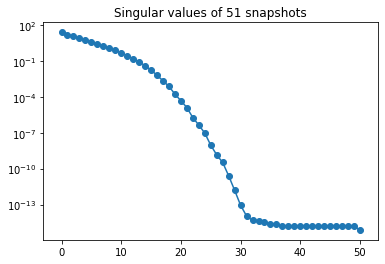

In [5]:
def s(x, mu):
    return (1-x)*np.cos(3*np.pi*mu*(x+1))*np.exp(-(1+x)*mu)

x = np.linspace(-1, 1, 100).reshape(-1,1)
mu = np.linspace(1, np.pi, 51).reshape(-1,1).T
f = s(x, mu) # shape = (space, parameters)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)
plt.plot(np.arange(sing_vals.shape[0]), sing_vals)
plt.scatter(np.arange(sing_vals.shape[0]), sing_vals)
plt.yscale("log")
plt.title("Singular values of 51 snapshots")
plt.show()

In [ ]:
RO_DIM = 30

# find solution to Poisson with homogeneous Dirichlet boundary conditions
# -u''(x; mu) = s(x; mu), u(0; mu) = u(1; mu) = 0.

sols = solution_fn(mu.reshape(-1), f) # shape = (params, space)

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

plt.scatter(np.arange(sing_vals.shape[0]), sing_vals)
plt.semilogy(np.arange(sing_vals.shape[0]), sing_vals)
plt.show()
print(V.shape)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ f[:, [i]]).reshape(-1)

In [ ]:
# Get DEIM indices
selected_indices = DEIM(u)

# plot POD basis vectors and first six spatial points
plt.scatter(x[selected_indices[:6]], np.zeros(6), c='black', label="EIM points")
for i in range(6):
    plt.plot(x, u[:, i], label=f"POD basis {i+1}")
plt.legend()
plt.show()

# look at DEIM approximations for these mu values and 10 DEIM modes
test_mu = [1.17, 1.5, 2.3, 3.1]
s_op = np.zeros((f.shape[0], 10)) # selection operator
for i, idx in enumerate(selected_indices[:10]):
    s_op[idx, i] = 1
DEIM_proj = u[:, :10] @ np.linalg.inv(s_op.T @ u[:, :10]) @ s_op.T # DEIM projection
for mu_val in test_mu:
    exact = s(x, mu_val)
    DEIM_approximation = DEIM_proj @ exact
    
    plt.plot(x, exact, label="exact", c='b')
    plt.plot(x, DEIM_approximation, label="DEIM approx", c='r', linestyle="dashed")
    plt.title(f"$\mu = {mu_val}$")
    plt.legend()
    plt.show()

# Compare Errors for POD, DEIM, Exact NEIM
Exact NEIM is the version of NEIM for nonlinearities which do not depend on solutions (they depend on space and parameters). In this case, NEIM should approximate constant vectors in its expansion, so we instead use these exact vectors.

**If you want better results for Exact NEIM, increase NUM_TRAIN_PARAMS**

[0, 15, 36, 7, 50]
0 Max Error: 29.34020414554605 Mean Error: 18.003543215002313
0 0.25873176654974106
100 0.1642288109283118
200 0.10248073953467667
300 0.0633293172459322
400 0.039101012470994456
500 0.024156782503623145
600 0.014892388753535336
700 0.009119459669211199
800 0.0055163599928923284
900 0.0032779599374842734
1000 0.0019044380307696315
1100 0.0010778486925689958
1200 0.0005926152909810655
1300 0.00031582014182929106
1400 0.00016281739155563364
1500 8.104895692682736e-05
1600 3.888609712119165e-05
1700 1.7950255177789817e-05
1800 7.958221997947871e-06
1900 3.382801983381172e-06
2000 1.376251178319463e-06
2100 5.349547211326201e-07
2200 1.9831625057445507e-07
2300 6.998938478645593e-08
2400 2.3472456028484517e-08
2500 7.469001691152323e-09
2600 2.2539096357711944e-09
2700 6.474447091101352e-10
2800 1.8056923853887897e-10
2900 5.2713708293753684e-11
3000 1.9655582560408867e-11
3100 1.146065335618467e-11
3200 9.376506549356087e-12
3300 8.706158369984177e-12
3400 8.35292899598

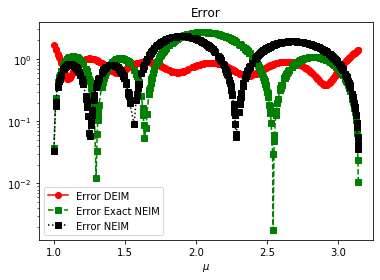

[0, 15, 36, 7, 50, 24, 3, 30, 43, 19]
0 Max Error: 29.34020414554605 Mean Error: 18.003543215002313
0 0.3845745889002734
100 0.2500290124706387
200 0.17918418242250067
300 0.1247689403163408
400 0.08158140880148955
500 0.04989729516674223
600 0.02894298783922548
700 0.016112934598803086
800 0.00863687549662605
900 0.004449245325582805
1000 0.002196140702151043
1100 0.001035840358069308
1200 0.0004658693573538335
1300 0.0001994749603741592
1400 8.121234114451008e-05
1500 3.1402986679178e-05
1600 1.1519119590916113e-05
1700 4.003006027548239e-06
1800 1.315881235863507e-06
1900 4.0853162914015727e-07
2000 1.1964321968494367e-07
2100 3.307992086240019e-08
2200 8.717634217330552e-09
2300 2.2888467844070112e-09
2400 6.981771768787785e-10
2500 3.2598077473134775e-10
2600 2.396694111556839e-10
2700 2.1584613201042584e-10
2800 2.0488786818960392e-10
2900 1.965965354435929e-10
3000 1.890324821418174e-10
3100 1.8184878819480747e-10
3200 1.7498070034286956e-10
3300 1.6840938903255805e-10
3400 1.62

4000 9.615202371093385e-11
4100 9.541884265728083e-11
4200 9.47289413398509e-11
4300 9.407863424526222e-11
4400 9.346463193279512e-11
4500 9.288399448568474e-11
4600 9.233409032264052e-11
4700 9.181255983001143e-11
4800 9.131728331329912e-11
4900 9.084635279782359e-11

Finding theta...
39 Max Error: 3.3835415992302806 Mean Error: 0.9281010289274038
0 0.401547233575221
100 0.26106255651224375
200 0.1888244294138132
300 0.13479636561965044
400 0.09275014119379876
500 0.05990267046569279
600 0.035289820701874836
700 0.018624955533555854
800 0.008858732544052176
900 0.003871213250454583
1000 0.0015754553099326172
1100 0.0006007640604823186
1200 0.00021544130753266004
1300 7.286509863943234e-05
1400 2.3284093281993555e-05
1500 7.033994375264958e-06
1600 2.0078498343413727e-06
1700 5.408539618327119e-07
1800 1.3725807760764504e-07
1900 3.280072164679839e-08
2000 7.431976736850832e-09
2100 1.6668978729961265e-09
2200 4.436207050337853e-10
2300 2.0062259703881733e-10
2400 1.5413018573519788e-1

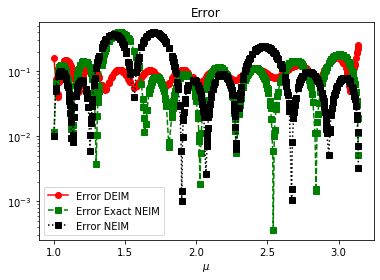

[0, 15, 36, 7, 50, 24, 3, 30, 43, 19, 11, 47, 27, 1, 39]
0 Max Error: 29.34020414554605 Mean Error: 18.003543215002313
0 0.4386535523184282
100 0.2923806766217206
200 0.18494163793719245
300 0.10007439162524075
400 0.05272053541717287
500 0.028470098070507814
600 0.0155436612070304
700 0.008413318411499188
800 0.004449675839073084
900 0.0022799563873568554
1000 0.0011277691045308048
1100 0.0005382750971587103
1200 0.0002481528445060449
1300 0.00011070578801142298
1400 4.793002042357333e-05
1500 2.0231348381289925e-05
1600 8.38568658022586e-06
1700 3.4487322776558803e-06
1800 1.426007705538188e-06
1900 6.010087233600838e-07
2000 2.6079752256168953e-07
2100 1.168260630984539e-07
2200 5.37588884613896e-08
2300 2.5195850548590237e-08
2400 1.1946803282923215e-08
2500 5.72668476317072e-09
2600 2.7960618619882613e-09
2700 1.4125871464367389e-09
2800 7.537062593036261e-10
2900 4.322787614841939e-10
3000 2.683176748311737e-10
3100 1.792394536678665e-10
3200 1.2733659625080992e-10
3300 9.5153488

4000 1.4156692378702337e-10
4100 1.3685772768749754e-10
4200 1.3257751172426098e-10
4300 1.2869027844251158e-10
4400 1.251622837147652e-10
4500 1.2196202118216387e-10
4600 1.1906018405392398e-10
4700 1.1642960778774567e-10
4800 1.1404519717144182e-10
4900 1.1188384115493383e-10

Finding theta...
39 Max Error: 3.3835415504806834 Mean Error: 0.9281010146067746
0 0.3393409427856171
100 0.23079853742942302
200 0.1554721483959213
300 0.0862712916028498
400 0.03602300855368296
500 0.011855157318023139
600 0.0036726151589649863
700 0.0013894879962361084
800 0.000796339356265842
900 0.0006230066523250951
1000 0.0005478005134039332
1100 0.000497125765875838
1200 0.00045476392810699063
1300 0.00041701251057622954
1400 0.00038283656114756933
1500 0.00035177064482188496
1600 0.0003234855353676072
1700 0.0002977021697077908
1800 0.00027417268579825563
1900 0.0002526719628536809
2000 0.00023299095804081587
2100 0.0002149317956805035
2200 0.00019830462937975353
2300 0.00018292559776505218
2400 0.0001

3000 1.741008092113016e-05
3100 1.7363896379986238e-05
3200 1.7337136003042724e-05
3300 1.732192205965037e-05
3400 1.7313421067741795e-05
3500 1.7308735374369808e-05
3600 1.7306169998749734e-05
3700 1.730475807050839e-05
3800 1.7303961796183722e-05
3900 1.7303489407057432e-05
4000 1.730318637412253e-05
4100 1.7302972652562253e-05
4200 1.7302807538417217e-05
4300 1.7302670562653647e-05
4400 1.7302551406813636e-05
4500 1.7302444735032084e-05
4600 1.730234762171721e-05
4700 1.7302258306783794e-05
4800 1.7302175608464373e-05
4900 1.7302098651483814e-05

Finding theta...
9 Max Error: 0.02194308157329594 Mean Error: 0.0027904564826458245
0 0.3473264021855386
100 0.24336827445107956
200 0.15519187554668515
300 0.08990804682509887
400 0.04980594343031491
500 0.026994442689589074
600 0.014354538043991118
700 0.0075658857913747535
800 0.004003473774367683
900 0.0021249674189838825
1000 0.0011168361103277155
1100 0.0005728538641000947
1200 0.0002837234535568184
1300 0.00013479391777130486
1400 6.

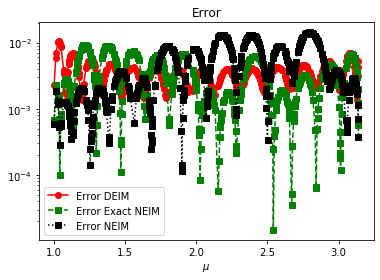

In [40]:
MAX_MODES = 15
NUM_TRAIN_PARAMS = 51
NUM_SPATIAL_POINTS = 100
x = np.linspace(-1, 1, NUM_SPATIAL_POINTS).reshape(-1,1)
mu = np.linspace(1, np.pi, NUM_TRAIN_PARAMS).reshape(-1,1).T
f = s(x, mu)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)

RO_DIM = 30

# find solution to Poisson with homogeneous Dirichlet boundary conditions
# -u''(x; mu) = s(x; mu), u(0; mu) = u(1; mu) = 0.

sols = solution_fn(mu.reshape(-1), f) # shape = (params, space)

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM))
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ f[:, [i]]).reshape(-1)

test_mu = np.sort(np.random.uniform(size=501)*(np.pi-1)+1)
#test_mu = np.linspace(1, np.pi, 534).reshape(-1, 1).T
DEIM_errors = []
POD_errors = []
Exact_NEIM_errors = []
Actual_NEIM_errors = []
for num_modes in range(5, MAX_MODES+1, 5):
    s_op = np.zeros((f.shape[0], num_modes)) # selection operator
    for i, idx in enumerate(DEIM(u)[:num_modes]):
        s_op[idx, i] = 1
    DEIM_proj = u[:, :num_modes] @ np.linalg.inv(s_op.T @ u[:, :num_modes]) @ s_op.T # DEIM projection
    Exact_NEIM_approximation, Exact_NEIM_selected_indices = Exact_NEIM(mu.reshape(-1), f, u, num_modes)
    print(Exact_NEIM_selected_indices)
    NEIM_approximation, NEIM_selected_indices = NEIM(ro_sols, f_NEIM, mu.reshape(-1), V[:, :RO_DIM], max_modes=num_modes, train_loop_iterations=5000) 
    print(NEIM_selected_indices)
    
    exact = V[:, :RO_DIM] @ V[:, :RO_DIM].T @ s(x, test_mu)
    DEIM_approximation = V[:, :RO_DIM] @ V[:, :RO_DIM].T @ DEIM_proj @ s(x, test_mu)
    POD_approximation = V[:, :RO_DIM] @ V[:, :RO_DIM].T @ u[:, :num_modes] @ u[:, :num_modes].T @ exact
    Degenerate_NEIM_approximation = np.array([V[:, :RO_DIM] @ V[:, :RO_DIM].T @ Exact_NEIM_approximation(new_mu, num_modes) for new_mu in test_mu.reshape(-1)])[:, :, 0].T
    Actual_NEIM_approximation = np.array([NEIM_approximation(new_mu, (V[:, :RO_DIM].T @ solution_fn(np.array([[new_mu]]), s(x, new_mu)).reshape(-1, 1)).reshape(-1), num_modes) for new_mu in test_mu.reshape(-1)]).T
    
    avg_error = np.mean([np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])])
    DEIM_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - POD_approximation[:, i]) for i in range(exact.shape[1])])
    #POD_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - Degenerate_NEIM_approximation[:, i]) for i in range(exact.shape[1])])
    Exact_NEIM_errors.append(avg_error)
    avg_error = np.mean([np.linalg.norm(exact[:, i] - Actual_NEIM_approximation[:, i]) for i in range(exact.shape[1])])
    Actual_NEIM_errors.append(avg_error)
    
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - DEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='o', c='r', label="Error DEIM")
    #plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - POD_approximation[:, i]) for i in range(exact.shape[1])], marker='^', c='black', linestyle='dotted', label="Error POD")
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - Degenerate_NEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='s', c='g', linestyle='dashed', label="Error Exact NEIM")
    plt.plot(test_mu.reshape(-1), [np.linalg.norm(exact[:, i] - Actual_NEIM_approximation[:, i]) for i in range(exact.shape[1])], marker='s', c='black', linestyle='dotted', label="Error NEIM")
    plt.yscale("log")
    plt.legend()
    plt.xlabel("$\mu$")
    plt.title("Error")
    plt.show()

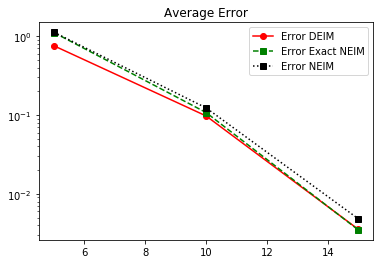

In [41]:
#print(DEIM_errors, "\n", POD_errors, "\n", Exact_NEIM_errors)    

plt.plot(np.arange(5, MAX_MODES+1, 5), DEIM_errors, marker='o', c='r', label="Error DEIM")
#plt.plot(np.arange(5, MAX_MODES+1, 5), POD_errors, marker='^', c='black', linestyle='dotted', label="Error POD")
plt.plot(np.arange(5, MAX_MODES+1, 5), Exact_NEIM_errors, marker='s', c='g', linestyle='dashed', label="Error Exact NEIM")
plt.plot(np.arange(5, MAX_MODES+1, 5), Actual_NEIM_errors, marker='s', c='black', linestyle='dotted', label="Error NEIM")
plt.yscale("log")
plt.legend()
plt.title("Average Error")
plt.show()

In [ ]:
NUM_TRAIN_PARAMS = 51
NUM_SPATIAL_POINTS = 100
x = np.linspace(-1, 1, NUM_SPATIAL_POINTS, dtype=np.double).reshape(-1,1)
mu = np.linspace(1, np.pi, NUM_TRAIN_PARAMS, dtype=np.double).reshape(-1,1).T
f = s(x, mu)

u, sing_vals, vh = np.linalg.svd(f, full_matrices=True)

RO_DIM = 30

# find solution to Poisson with homogeneous Dirichlet boundary conditions
# -u''(x; mu) = s(x; mu), u(0; mu) = u(1; mu) = 0.

sols = solution_fn(mu.reshape(-1), f) # shape = (params, space)

# do a POD based on sols
snapshots = np.array([sols[i] for i in range(sols.shape[0])]).T
V, sing_vals, _ = np.linalg.svd(snapshots, full_matrices=False)

# get reduced order solutions
ro_sols = np.zeros((sols.shape[0], RO_DIM), dtype=np.double)
for i in range(sols.shape[0]):
    ro_sols[i] = (V[:,:RO_DIM].T @ sols[i].reshape(-1, 1)).reshape(-1)

# evaluate nonlinearity at given parameter and solution
f_NEIM = np.zeros((sols.shape[0], sols.shape[0], RO_DIM), dtype=np.double)
for i in range(sols.shape[0]):
    for j in range(sols.shape[0]):
        f_NEIM[i, j] = (V[:,:RO_DIM].T @ f[:, [i]]).reshape(-1)

test_mu = np.sort(np.random.uniform(size=501)*(np.pi-1)+1)
num_modes = 5
NEIM_approximation, NEIM_selected_indices = NEIM(ro_sols, f_NEIM, mu.reshape(-1), V[:, :RO_DIM], max_modes=num_modes, train_loop_iterations=50000) 


In [ ]:
approx0 = NEIM_approximation(3.0, ro_sols[0], num_modes=1)
for i in range(ro_sols.shape[0]):
    print(np.linalg.norm(NEIM_approximation(3.0, ro_sols[i], num_modes=1) - approx0))